In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/d1intextorg1/Arshad D1.xlsx
/kaggle/input/cohenintextorg2/Chohen intext org.xlsx


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from gensim.models import Word2Vec
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data = pd.read_excel('/kaggle/input/newdatasetd2/D2.xlsx', sheet_name='CitationSentences')
data.head()

,Root_Paper_ID,Cited-by_Paper_ID,ExtractedCitationSentence,CitationClass
0,A00-1043,C00-2140,since we only use shallow methods for textual ...,0
1,A00-1043,P02-1057,sentence simplification systems are capable of...,0
2,A97-1011,W09-1118,each token is represented using a fairly stand...,0
3,A97-1011,A00-2017,the training and the test data were processed ...,0
4,A97-1011,C00-2099,the only other high delity computational rende...,0


In [4]:
data = data.drop(['Root_Paper_ID', 'Cited-by_Paper_ID'], axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data['ExtractedCitationSentence'], data['CitationClass'], test_size=0.2, random_state=42)

In [6]:
stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = text.lower()
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)


In [7]:
# Train the Word2Vec model
sentences = [sentence.split() for sentence in X_train]
w2v_model = Word2Vec(sentences, vector_size=100, window=15, min_count=5, workers=4)

# Vectorize the text data
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train = np.array([vectorize(sentence) for sentence in X_train])
X_test = np.array([vectorize(sentence) for sentence in X_test])


In [8]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [9]:
# Check the balance of the dataset after applying SMOTE
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))
print("Class Counts after SMOTE:", class_counts)

Class Counts after SMOTE: {0: 342, 1: 342}


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define parameter grid for SVM
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Create an SVM classifier
svm_clf = SVC()

# Create GridSearchCV instance
svm_grid_search = GridSearchCV(svm_clf, svm_param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV
svm_grid_search.fit(X_train, y_train)

# Get the best SVM model from GridSearchCV
best_svm_clf = svm_grid_search.best_estimator_

# Predict using the best SVM model
best_svm_y_pred = best_svm_clf.predict(X_test)

# Calculate metrics for the best SVM model
best_svm_accuracy = accuracy_score(y_test, best_svm_y_pred)
best_svm_precision = precision_score(y_test, best_svm_y_pred, average='macro')
best_svm_recall = recall_score(y_test, best_svm_y_pred, average='macro')
best_svm_f1 = f1_score(y_test, best_svm_y_pred, average='macro')

print('Best SVM - Accuracy:', best_svm_accuracy)
print('Best SVM - Precision (Overall):', best_svm_precision)
print('Best SVM - Recall (Overall):', best_svm_recall)
print('Best SVM - F1 score (Overall):', best_svm_f1)
print('Best SVM - Best Parameters:', svm_grid_search.best_params_)


Best SVM - Accuracy: 0.5899280575539568
Best SVM - Precision (Overall): 0.6330969267139479
Best SVM - Recall (Overall): 0.6192796610169492
Best SVM - F1 score (Overall): 0.5857254901960784
Best SVM - Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [13]:
from sklearn.naive_bayes import GaussianNB

# Create a Naive Bayes classifier
nb_clf = GaussianNB()

# Train the Naive Bayes classifier
nb_clf.fit(X_train, y_train)

# Predict using the Naive Bayes classifier
nb_y_pred = nb_clf.predict(X_test)

# Calculate metrics for Naive Bayes classifier
nb_accuracy = accuracy_score(y_test, nb_y_pred)
nb_precision = precision_score(y_test, nb_y_pred, average='macro')
nb_recall = recall_score(y_test, nb_y_pred, average='macro')
nb_f1 = f1_score(y_test, nb_y_pred, average='macro')

print('Naive Bayes - Accuracy:', nb_accuracy)
print('Naive Bayes - Precision (Overall):', nb_precision)
print('Naive Bayes - Recall (Overall):', nb_recall)
print('Naive Bayes - F1 score (Overall):', nb_f1)


Naive Bayes - Accuracy: 0.5251798561151079
Naive Bayes - Precision (Overall): 0.5246376811594202
Naive Bayes - Recall (Overall): 0.5252118644067797
Naive Bayes - F1 score (Overall): 0.5221875


In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define parameter grid for Decision Tree
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Create a Decision Tree classifier
dt_clf = DecisionTreeClassifier()

# Create GridSearchCV instance
dt_grid_search = GridSearchCV(dt_clf, dt_param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV
dt_grid_search.fit(X_train, y_train)

# Get the best Decision Tree model from GridSearchCV
best_dt_clf = dt_grid_search.best_estimator_

# Predict using the best Decision Tree model
best_dt_y_pred = best_dt_clf.predict(X_test)

# Calculate metrics for the best Decision Tree model
best_dt_accuracy = accuracy_score(y_test, best_dt_y_pred)
best_dt_precision_macro = precision_score(y_test, best_dt_y_pred, average='macro')
best_dt_recall_macro = recall_score(y_test, best_dt_y_pred, average='macro')
best_dt_f1_macro = f1_score(y_test, best_dt_y_pred, average='macro')

print('Best Decision Tree - Accuracy:', best_dt_accuracy)
print('Best Decision Tree - Precision (Macro):', best_dt_precision_macro)
print('Best Decision Tree - Recall (Macro):', best_dt_recall_macro)
print('Best Decision Tree - F1 score (Macro):', best_dt_f1_macro)
print('Best Decision Tree - Best Parameters:', dt_grid_search.best_params_)


Best Decision Tree - Accuracy: 0.5107913669064749
Best Decision Tree - Precision (Macro): 0.5059251559251559
Best Decision Tree - Recall (Macro): 0.5060381355932203
Best Decision Tree - F1 score (Macro): 0.5050272308336825
Best Decision Tree - Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10}


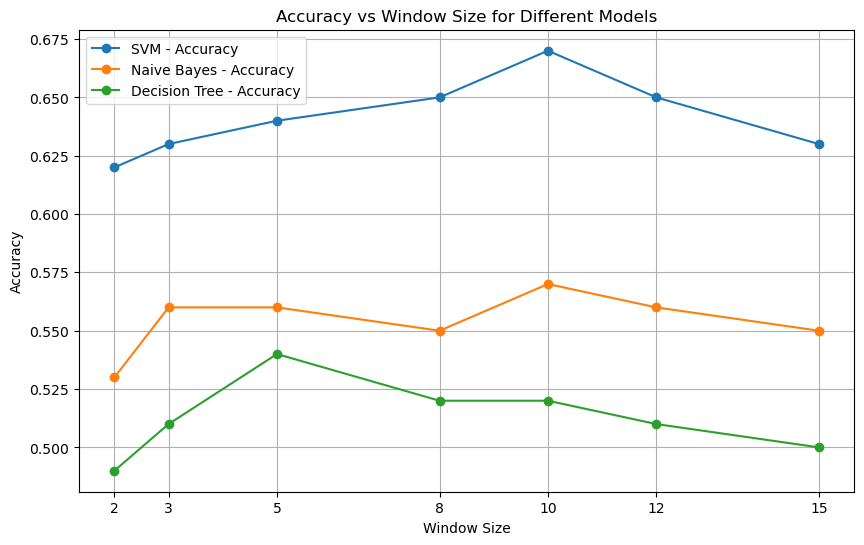

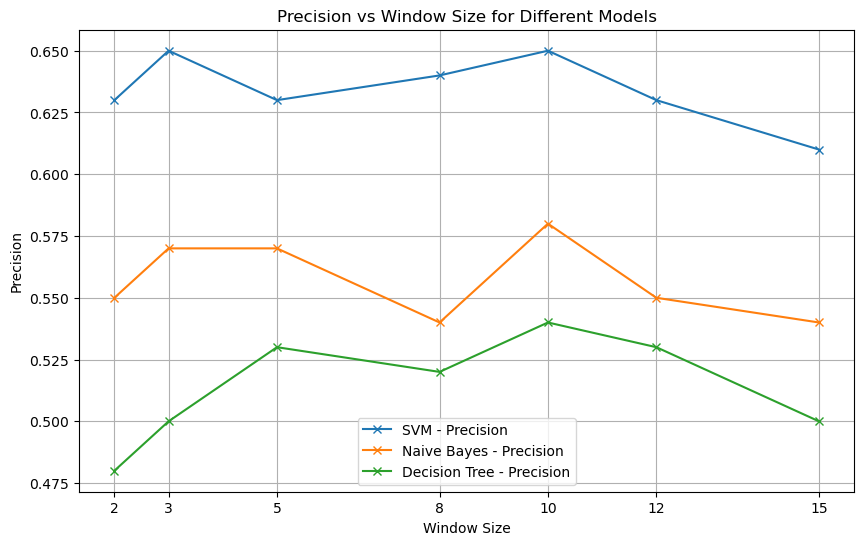

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from Excel file
file_path = "/kaggle/input/newdatasetd2/D2.xlsx"  # Replace with the actual file path
sheet_name = "Results"  # Specify the sheet name

data = pd.read_excel(file_path, sheet_name=sheet_name)

# Ensure columns match expected structure
columns = ['Model', 'Window Size', 'Accuracy', 'Precision']
data = data[columns]

# Plot 1: Accuracy vs Window Size for each model
plt.figure(figsize=(10, 6))
for model in data['Model'].unique():
    model_data = data[data['Model'] == model]
    plt.plot(model_data['Window Size'], model_data['Accuracy'], marker='o', label=f'{model} - Accuracy')

# Adding labels and title for Accuracy plot
plt.xlabel('Window Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Window Size for Different Models')
plt.legend()
plt.grid(True)
plt.xticks([2, 3, 5, 8, 10, 12, 15])

# Display Accuracy plot
plt.show()

# Plot 2: Precision vs Window Size for each model
plt.figure(figsize=(10, 6))
for model in data['Model'].unique():
    model_data = data[data['Model'] == model]
    plt.plot(model_data['Window Size'], model_data['Precision'], marker='x', label=f'{model} - Precision')

# Adding labels and title for Precision plot
plt.xlabel('Window Size')
plt.ylabel('Precision')
plt.title('Precision vs Window Size for Different Models')
plt.legend()
plt.grid(True)
plt.xticks([2, 3, 5, 8, 10, 12, 15])

# Display Precision plot
plt.show()
